In [1]:
import pandas as pd
import numpy as np
import os
import h5py
from copy import deepcopy
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')
import seaborn as sns

from utils_plot import *

cm = 1/2.54 
h=5.8*1.1
w=6*1.1

resp_res_path = '/cluster/work/grlab/clinical/hirid2/research/event_based_analysis/resp/'
renal_res_path = '/cluster/work/grlab/clinical/hirid2/research/kdigo_analysis/'
resp_fig_path = '../Figures_Resp'
renal_fig_path = 'paper_figures_renal'

In [2]:
# early warning system configuration
renal_ews_configs = dict()
renal_ews_configs.update(pred_win=2880)
renal_ews_configs.update(min_event_gap=0)
renal_ews_configs.update(t_silence=480)
renal_ews_configs.update(t_buffer=0)
renal_ews_configs.update(t_reset=720)

splits = ['temporal_%d'%i for i in np.arange(1,6)]
calibration = False

In [3]:
curve_ref = {"ref": dict(res_path=os.path.join(renal_res_path, "var28_simple_features_subcohort_male_separate_combined_calibrated_lgbm_test_FromZero"),
                         color='C0',
                         linestyle='-',
                         random_classifier=False,
                         splits=splits)}

for k in curve_ref.keys():
    curve_ref[k].update(dict(**renal_ews_configs))
    
plt.figure(figsize=(w*2*cm, h*cm))
_, prev_ref = plot_event_based_prc(curve_ref, fixed_rec=1.0)
plt.close()

In [4]:
curve = {"ref": dict(res_path=os.path.join(renal_res_path, "var28_simple_features_subcohort_female_separate_combined_calibrated_lgbm_test_FromZero"),
                     color='C0',
                     linestyle='-',
                     random_classifier=False,
                     splits=splits)}

for k in curve.keys():
    curve[k].update(dict(**renal_ews_configs))
    
plt.figure(figsize=(w*2*cm, h*cm))
_, prev_adj = plot_event_based_prc(curve, fixed_rec=1.0)
plt.close()

In [5]:
calibrated_s = (1/prev_ref-1) / (1/prev_adj-1)

In [6]:
curves = dict()
curves.update({"Male": dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_male_separate_combined_calibrated_lgbm_test_FromZero'),
                            color='C9',
                            linestyle='-',
                            sex="male",
                            random_classifier=False,
                            splits=splits)})

curves.update({"Female": dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_female_separate_combined_calibrated_lgbm_test_FromZero'),
                              color='C6',
                              linestyle='-',
                              random_classifier=False,
                              sex="female",
                              calibration_scaler=calibrated_s if calibration else 1,
                              splits=splits)})

for k in curves.keys():
    curves[k].update(dict(**renal_ews_configs))
    
curves_gbdt = deepcopy(curves)

In [7]:
curves = dict()
curves.update({"Male": dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_male_separate_combined_calibrated_lstm_test_FromZero'),
                            color='C9',
                            linestyle='-',
                            sex="male",
                            random_classifier=False,
                            splits=splits)})

curves.update({"Female": dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_female_separate_combined_calibrated_lstm_test_FromZero'),
                              color='C6',
                              linestyle='-',
                              random_classifier=False,
                              sex="female",
                              calibration_scaler=calibrated_s if calibration else 1,
                              splits=splits)})

for k in curves.keys():
    curves[k].update(dict(**renal_ews_configs))
    
curves_lstm = deepcopy(curves)

In [8]:
plt.figure(figsize=(w*2*cm, h*0.5*cm))
metric_gbdt, _ = plot_metric_vs_setting(curves_gbdt,xlabel="sex")
metric_lstm, _ = plot_metric_vs_setting(curves_lstm,xlabel="sex")
plt.close()

In [9]:
all_metric = []
xticks = [curves_gbdt[model]["sex"] for model in curves_gbdt.keys()]
for model, metric in [("Time-stacked GBDT-snapshot", metric_gbdt),
                      ("LSTM", metric_lstm)]:
    metric.loc[:,"Model"] = model
    all_metric.append(metric)
    
all_metric = pd.concat(all_metric).reset_index(drop=True)

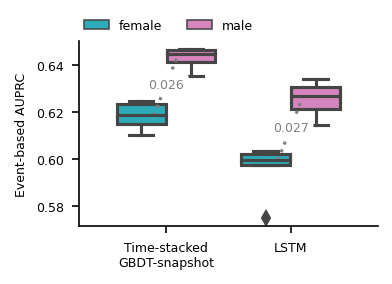

In [10]:
plt.figure(figsize=(w*cm, h*0.75*cm))

sns.boxplot(all_metric, x="Model", y="metric", order=["Time-stacked GBDT-snapshot","LSTM"], 
            hue="sex", hue_order=["female", "male"], palette=["C9", "C6"])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncols=3, borderaxespad=0.)

median = all_metric.groupby(["Model","sex"]).median()
for i, model in enumerate(["Time-stacked GBDT-snapshot","LSTM"]):
    yvals = [median.loc[(model,sex),"metric"] for sex in ["female", "male"]]
    plt.plot([i-0.1,i+0.1], yvals, color="C7", linestyle=":")
    plt.text(i, np.mean(yvals), "%3.3f"%np.abs(np.diff(yvals)[0]), 
             color="C7",ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 1., 1.),
                       fc=(1., 1., 1.),
                       ))

plt.xlabel("")
plt.ylabel("Event-based AUPRC")
plt.xticks(range(2), ["Time-stacked\nGBDT-snapshot","LSTM"])
plt.tight_layout()
plt.savefig(os.path.join(renal_fig_path,'sex_fairness_calibrated' if calibration else 'sex_fairness_uncalibrated'))
plt.show()  

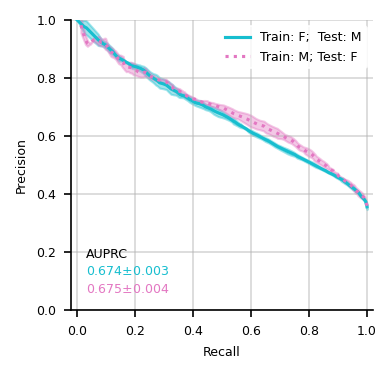

In [11]:
curves = dict()
curves.update({"Train: F;  Test: M": dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_male_separate_combined_calibrated_lgbm_female_test_FromZero'),
                                             color='C9',
                                             linestyle='-',
                                             random_classifier=False,
                                             splits=splits)})

curves.update({"Train: M; Test: F": dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_female_separate_combined_calibrated_lgbm_male_test_FromZero'),
                                             color='C6',
                                             linestyle=':',
                                             random_classifier=False,
                                             calibration_scaler=calibrated_s,                 
                                             splits=splits)})


for k in curves.keys():
    curves[k].update(dict(**renal_ews_configs))
    
plt.figure(figsize=(w*cm, h*cm))
plot_event_based_prc(curves, fixed_rec=1.0)
plt.savefig(os.path.join(renal_fig_path,'gbdt_gender_fairness_calibrated' if calibration else'gbdt_gender_fairness_uncalibrated'))
plt.show() 

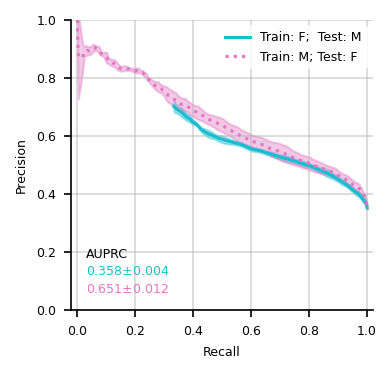

In [12]:
curves = dict()
curves.update({"Train: F;  Test: M": dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_male_lstm_female_test_FromZero'),
                                             color='C9',
                                             linestyle='-',
                                             random_classifier=False,
                                             splits=splits)})

curves.update({"Train: M; Test: F": dict(res_path=os.path.join(renal_res_path, 'var28_simple_features_subcohort_female_lstm_male_test_FromZero'),
                                             color='C6',
                                             linestyle=':',
                                             random_classifier=False,
                                             calibration_scaler=calibrated_s,                 
                                             splits=splits)})


for k in curves.keys():
    curves[k].update(dict(**renal_ews_configs))
    
plt.figure(figsize=(w*cm, h*cm))
plot_event_based_prc(curves, fixed_rec=1.0)
plt.savefig(os.path.join(renal_fig_path,'lstm_gender_fairness_calibrated' if calibration else'lstm_gender_fairness_uncalibrated'))
plt.show() 